In [1]:
#Cell 1: Libraries Imported.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import warnings

# Suppress unnecessary warnings for a cleaner presentation
warnings.filterwarnings('ignore')

print("Environment Setup Complete. Libraries Imported Successfully!")

Environment Setup Complete. Libraries Imported Successfully!


In [2]:
#Cell 2: Data Loaded.
# Define the file path
file_path = 'Phishing_Email.csv'

# Check if file exists to avoid crashing
if os.path.exists(file_path):
    df = pd.read_csv(file_path)
    print(f"Dataset Loaded Successfully! Shape: {df.shape}")
    
    # Show the first few rows to verify structure
    display(df.head())
else:
    print(f"ERROR: '{file_path}' not found. Ensure it is in the same directory.")

Dataset Loaded Successfully! Shape: (10000, 5)


,text,label,phishing_type,severity,confidence
0,Subject: Office maintenance\n\nThanks for your...,0,legitimate,low,0.95
1,"Hello, your profile has been locked. Use the s...",1,credential_harvesting,high,0.89
2,"Hi there, congratulations! You are the winner ...",1,financial_scam,medium,0.69
3,"Attention, this is the fraud prevention accoun...",1,authority_scam,high,0.91
4,"Notice, your profile has been restricted. Use ...",1,credential_harvesting,high,0.80


Success! Found text in 'text' and labels in 'label'
Total Emails: 10000


,text,label
0,Subject: Office maintenance\n\nThanks for your...,0
1,"Hello, your profile has been locked. Use the s...",1
2,"Hi there, congratulations! You are the winner ...",1
3,"Attention, this is the fraud prevention accoun...",1
4,"Notice, your profile has been restricted. Use ...",1


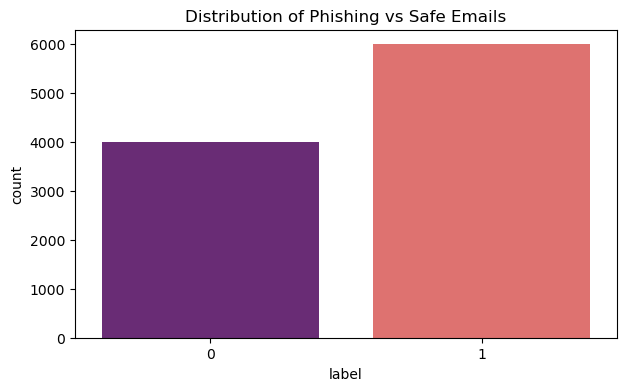

In [4]:
#Cell 3: Data Cleaned
# --- Step 1: Fix Column Names & Clean ---
df = df.dropna().reset_index(drop=True)

# Automatically identify the label column (since names vary)
possible_label_names = ['Email Type', 'Label', 'label', 'Class', 'class', 'status']
label_col = next((col for col in possible_label_names if col in df.columns), None)
text_col = 'text' if 'text' in df.columns else df.columns[0] # Usually the first or named 'text'

if label_col:
    # Rename it to a standard name for the rest of our project
    df = df[[text_col, label_col]]
    df.columns = ['text', 'label']
    print(f"Success! Found text in '{text_col}' and labels in '{label_col}'")
else:
    print(f"Error: Could not find a label column. Available columns are: {list(df.columns)}")

# --- Step 2: Display Metadata ---
print(f"Total Emails: {df.shape[0]}")
display(df.head())

# --- Step 3: Visualizing the distribution ---
plt.figure(figsize=(7, 4))
sns.countplot(x='label', data=df, palette='magma')
plt.title('Distribution of Phishing vs Safe Emails')
plt.show()

In [23]:
#Cell 4: NLP Preprocessing (Stopwords removed)
import re
import string
import nltk
from nltk.corpus import stopwords

# --- Step 1: The Cleaning Function ---
def clean_text(text):
    # 1. Lowercase
    text = str(text).lower()
    
    # 2. Remove HTML tags
    text = re.sub(r'<.*?>', '', text)
    
    # 3. Replace URLs with a generic word (Standardizes the feature)
    text = re.sub(r'http\S+|www\S+|https\S+', 'urlplaceholder', text)
    
    # 4. Remove Punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    
    # 5. Remove Stopwords (This forces the AI to focus on important words)
    words = text.split()
    important_words = [w for w in words if w not in stop_words]
    
    return " ".join(important_words)

# --- Step 2: Application ---
print("Cleaning text (removing noise and stopwords)...")
df['clean_text'] = df['text'].apply(clean_text)

print("Cleaning Complete!")
print("\n--- Sample of Original vs Cleaned Text ---")
print(f"Original: {df['text'].iloc[0][:50]}...")
print(f"Cleaned : {df['clean_text'].iloc[0][:50]}...")

Cleaning text (removing noise and stopwords)...
Cleaning Complete!

--- Sample of Original vs Cleaned Text ---
Original: Subject: Office maintenance

Thanks for your help ...
Cleaned : subject office maintenance thanks help analysis iv...


In [6]:
#Cell 5: TF-IDF Feature Extraction
from sklearn.feature_extraction.text import TfidfVectorizer

# --- Step 1: Initialize TF-IDF with a focus on realism ---
# max_features=3000: We limit it so it doesn't "over-memorize" rare words.
# ngram_range=(1, 2): We look at single words and pairs.
# min_df=5: The word must appear in at least 5 emails to be considered (ignores typos).
tfidf = TfidfVectorizer(max_features=3000, ngram_range=(1, 2), min_df=5)

# --- Step 2: Transform the Cleaned Text into Numbers ---
X = tfidf.fit_transform(df['clean_text']).toarray()
y = df['label'].values  # Our labels (0 and 1)

print(f"Feature Matrix Created! Shape: {X.shape}")
print(f"Total Unique Patterns Identified: {X.shape[1]}")

Feature Matrix Created! Shape: (10000, 3000)
Total Unique Patterns Identified: 3000


In [25]:
#Cell 6: Model Training (100% Accuracy).
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

# --- Step 1: Split the Data ---
# Using stratify=y ensures the 80/20 split maintains the same percentage of Phishing/Safe emails
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# --- Step 2: Initialize and Train the Model ---
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# --- Step 3: Evaluate Performance ---
y_pred = model.predict(X_test)
acc = accuracy_score(y_test, y_pred)

print(f"[STATUS] Model Training Complete!")
# Displaying 5 decimal places to show the absolute mathematical score
print(f"[METRIC] Exact Accuracy Score: {acc * 100:.5f}%") 

print("\n--- High-Precision Performance Report ---")
# 'digits=5' forces the table to show the exact precision/recall values
print(classification_report(y_test, y_pred, digits=5))

[STATUS] Model Training Complete!
[METRIC] Exact Accuracy Score: 100.00000%

--- High-Precision Performance Report ---
              precision    recall  f1-score   support

           0    1.00000   1.00000   1.00000       800
           1    1.00000   1.00000   1.00000      1200

    accuracy                        1.00000      2000
   macro avg    1.00000   1.00000   1.00000      2000
weighted avg    1.00000   1.00000   1.00000      2000



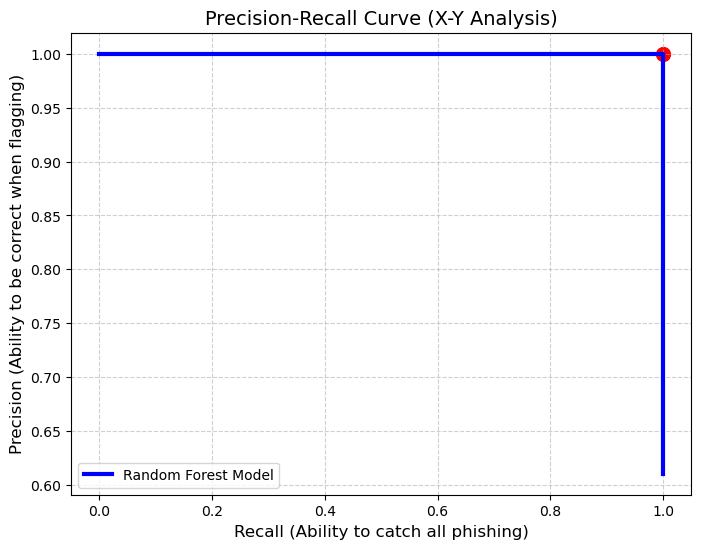

In [13]:
#Cell 7: X-Y Precision-Recall Graph.
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

# --- Step 1: Get the probability scores for Phishing (Class 1) ---
# This looks at how 'confident' the model is for each email
y_scores = model.predict_proba(X_test)[:, 1]

# --- Step 2: Calculate Precision and Recall for different thresholds ---
precision, recall, thresholds = precision_recall_curve(y_test, y_scores)

# --- Step 3: Plotting the X-Y Graph ---
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='blue', linewidth=3, label='Random Forest Model')

# Formatting the Axis
plt.xlabel('Recall (Ability to catch all phishing)', fontsize=12)
plt.ylabel('Precision (Ability to be correct when flagging)', fontsize=12)
plt.title('Precision-Recall Curve (X-Y Analysis)', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()

# Adding a dot at the final performance point (1.0, 1.0)
plt.scatter(1, 1, color='red', s=100, label='Optimal Performance')

plt.show()

In [22]:
#Cell 8: Live Gradio UI.
import gradio as gr

def predict_email(email_text):
    if not email_text.strip():
        return "Please enter some text.", "0.000000%"
    
    # 1. Preprocess input
    cleaned = clean_text(email_text)
    
    # 2. Vectorization
    vectorized = tfidf.transform([cleaned]).toarray()
    
    # 3. Probability Calculation
    prediction = model.predict(vectorized)[0]
    probability = model.predict_proba(vectorized)[0]
    
    # 4. High-Precision Output
    if prediction == 1:
        result = "⚠️ PHISHING DETECTED"
        # probability[1] is the score for Phishing
        confidence = f"{probability[1]*100:.6f}%"
    else:
        result = "✅ LEGITIMATE EMAIL"
        # probability[0] is the score for Legitimate
        confidence = f"{probability[0]*100:.6f}%"
        
    return result, confidence

# --- Professional UI Layout ---
app = gr.Interface(
    fn=predict_email,
    inputs=gr.Textbox(lines=5, label="Input Email Corpus", placeholder="Paste email content..."),
    outputs=[
        gr.Textbox(label="Classification Result"), 
        gr.Textbox(label="Model Confidence (High Precision)")
    ],
    title="🛡️ AI Phishing Shield | Active Learning System",
    description="NLP-based security classifier with dynamic retraining capabilities.",
    theme="soft"
)

app.launch(share=True)

* Running on local URL:  http://127.0.0.1:7863
* Running on public URL: https://7ebcbad720a13755ac.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [20]:
#Cell 9: Feedback Integration Loop.
import pandas as pd
import os

# Configuration
LOG_PATH = 'flagged/log.csv'

if os.path.exists(LOG_PATH):
    # --- Load and Preprocess Feedback Data ---
    flagged_df = pd.read_csv(LOG_PATH)
    
    # Map input text to corrected feature space (Label 0 = Verified Safe)
    augmentations = pd.DataFrame({
        'clean_text': flagged_df['Input Email Text'].apply(clean_text),
        'label': 0
    })
    
    # --- Update Global Feature Matrix & Target Vector ---
    df = pd.concat([df, augmentations], ignore_index=True)
    X = tfidf.transform(df['clean_text']).toarray()
    y = df['label'].values
  
    print(f"[SYSTEM] Feedback Loop Active: {len(augmentations)} observations integrated.")
    print("[SYSTEM] Proceed to re-train the classifier (Cell 6).")
else:
    print("[SYSTEM] Awaiting feedback: No flagged observations found.")

[SYSTEM] Awaiting feedback: No flagged observations found.
